In [1]:
import oceanspy as ospy
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import scipy as sp
from detection import eddyDetection
import ast
from tqdm import tqdm
from detection import newEddyMethod
from IPython.display import Video, display
from animation import animation_local_gif
from PIL import Image
import IPython.display as ipy_display
import ipywidgets as widgets

In [2]:
df_OW = xr.open_dataset('C:/Users/eirik/Master/Data/Horizontal_Okubo_weiss.nc')['Okubo_Weiss']
df_OW = df_OW*(1/(10**(-9)))
df_eta = xr.open_dataset('C:/Users/eirik/Master/Data/Horizontal_Eta.nc')['Eta']
df_hor_vel = xr.open_dataset('C:/Users/eirik/Master/Data/Horizontal_hor_vel.nc')['hor_vel']

In [3]:
# Inner domain
domain_center = [[-20,0],[71,74]]
OW_center = df_OW.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1])).sel(Z=-1)
eta_center = df_eta.sel(X=slice(domain_center[0][0],domain_center[0][1])).sel(Y=slice(domain_center[1][0],domain_center[1][1]))

# Outer domain
eta = df_eta.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1))
OW = df_OW.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-1,domain_center[1][1]+1)).sel(Z=-1)

# Resample data
eta = eta.resample(time='D').mean(dim='time')
eta_center = eta_center.resample(time='D').mean(dim='time')
OW = OW.resample(time='D').mean(dim='time')
OW_center = OW_center.resample(time='D').mean(dim='time')
hor_vel = df_hor_vel.resample(time='D').mean(dim='time')

# Define time extent
time = ['2018-01-01T00:00:00.000000000','2018-01-02T00:00:00.000000000']
eta = eta.sel(time=slice(time[0],time[1]))
eta_center = eta_center.sel(time=slice(time[0],time[1]))
OW = OW.sel(time=slice(time[0],time[1]))
OW_center = OW_center.sel(time=slice(time[0],time[1]))
hor_vel = hor_vel.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))

In [4]:
# Set True to run, or read previously file made
run = input('Would you like to run a new dataset? y/n: ')
if run == 'y':
    run = True
elif run == 'n':
    run = False
if run:
    eddyLocation = []
    print('###Applying filter###')
    for i in range(len(eta)):
        eddyLocation.append(eddyDetection(eta_center[i],OW_center[i]))
        print('Processing: ',100*(i+1)/len(eta_center), '%')
    with open("eddyCenterpoints_test2.txt",'w') as f:
        for time in range(len(eddyLocation)):
            if time != len(eddyLocation)-1:
                f.write(str(eddyLocation[time])+',')
            else:
                f.write(str(eddyLocation[time]))

else:
    print('###Loading previously saved eddy centerpoints###')
    with open("eddyCenterpoints_test2.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)

###Loading previously saved eddy centerpoints###


In [5]:
OW

<xarray.DataArray 'Okubo_Weiss' (time: 2, Y: 231, X: 510)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 1.10551784e+00,  9.31475352e-01,  3.07817506e-02, ...,
          1.45466513e-01,  1.95109506e-01,  8.99655915e-02],
        [-1.86027550e-01,  6.78815032e-01,  6.99031605e-02, ...,
          2.04721275e-01,  1.65334675e-01,  7.57539281e-02],
        ...,
        [            nan,             nan,             nan, ...,
         -1.20062086e-02,  1.36449978e-02,  1.81685063e-02],
        [            nan,             nan,             nan, ...,
         -1.14532871e-04,  5.99252845e-03,  3.08898786e-02],
        [            nan,             nan,             nan, ...,
          3.82889751e-02,  6.31200198e-02,  5.17110214e-02]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 9.76701596e-01,  5.05255806e-01,  2.76609644e-01, ...,
          1.31804512e-01,  3.64348225e-01,  4.52378167e-01],
        [ 3.53711932e-01,  2.35796811e-01,  2.83982026e-01, ...,
          1.36107722e-01,  1.49863076e-01,  2.87893745e-01],
        ...,
        [            nan,             nan,             nan, ...,
          7.98100764e-02,  5.46199923e-02, -2.75575004e-02],
        [            nan,             nan,             nan, ...,
          6.80720596e-02,  2.29604214e-02, -8.04953310e-03],
        [            nan,             nan,             nan, ...,
          2.40386717e-02,  2.76888143e-02,  5.42407432e-02]]])
Coordinates:
    Z        float64 -1.0
  * X        (X) float64 -21.98 -21.93 -21.87 -21.82 ... 1.822 1.879 1.936 1.994
  * Y        (Y) float64 70.01 70.03 70.04 70.06 ... 74.89 74.92 74.95 74.99
    XC       (Y, X) float64 ...
    YC       (Y, X) float64 ...
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02

In [6]:
run = input('Would you like to run a new dataset? y/n: ')
if run == 'y':
    run = True
elif run == 'n':
    run = False

if run:
    eddy_centers = eddyLocation
    T = len(eddyLocation)
    pbar = tqdm(total=T, desc="Running algorythm")
    eddies = xr.full_like(eta,fill_value=0)
    eddies = eddies.rename("EddyDetection")
    for time in range(0,1):
        # First run per time step
        
        
        eddyDataset = newEddyMethod(OW=OW[time],hor_vel=hor_vel[time],eddy_center=eddy_centers[time][0][0],warm=True,eddiesDataset=eddies[time])
        
        for i in range(1,len(eddy_centers[time][0])):
            eddyDataset = newEddyMethod(OW=OW[time],hor_vel=hor_vel[time],eddy_center=eddy_centers[time][0][i],warm=True,eddiesDataset=eddyDataset)
            
        for i in range(0,len(eddy_centers[time][1])):
            eddyDataset = newEddyMethod(OW=OW[time],hor_vel=hor_vel[time],eddy_center=eddy_centers[time][1][i],cold=True,eddiesDataset=eddyDataset)
        
        pbar.update(1)
        eddies[time] = eddyDataset
    eddies.to_netcdf('C:/Users/eirik/Master/Data/EddiesTest2.nc')
else:
    eddies = xr.open_dataset('C:/Users/eirik/Master/Data/EddiesTest2.nc')
    eddies = eddies['EddyDetection']

Running algorythm:  50%|█████     | 1/2 [00:02<00:02,  2.94s/it]

<xarray.DataArray 'EddyDetection' (time: 2, Y: 231, X: 510)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * X        (X) float64 -21.98 -21.93 -21.87 -21.82 ... 1.822 1.879 1.936 1.994
  * Y        (Y) float64 70.01 70.03 70.04 70.06 ... 74.89 74.92 74.95 74.99
    XC       (Y, X) float64 ...
    YC       (Y, X) float64 ...
  * time     (time) datetime64[ns] 2018-01-01 2018-01-02
Attributes:
    long_name:      free-surface_r-anomaly
    units:          m
    standard_name:  sea_surface_height_above_geoid
    _coordinates:   XC YC iter

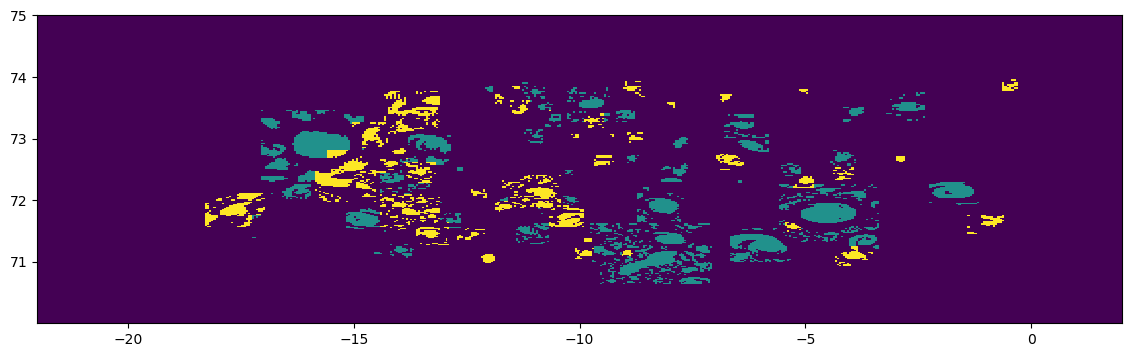

In [8]:
display(eddies)

fig , ax = plt.subplots(figsize=(14,4),layout='constrained')
ax.pcolormesh(eddies.X,eddies.Y,eddies[0])